# How Long to Buid a Settlement on Mars

This basically comes down to three questions

1. How much crap do we need on the surface?
2. How good is our ship and how many do we have?
3. How many launch oppurtunities do we have?

## How much crap do we need to put on the surface?

To simplifiy this part we will be using mass/settler as our base measure for calculation. A good terresterial analog we can use to obtain this measure is an aircraft carrier. This comes out to 17 tons per settler, or 17 * 100,000 = 1,700,000 tons for the whole settlement.

## How good is our ship and how many do we have?

Our ship is the Space X Starship with a payload mass of 150 tons. We will assume we have a fleet of 200.

## How many launch oppurtunities do we have?

This is dependant on where we want to go, Mars in this case, and how much delta v our ship can provide

In [1]:
import pygmo as pg
import pykep as pk
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## Define a date range for our problem

In [6]:
start_date = 7305.0 
end_date = 7671.0
intervals = 1.0
start_epochs = np.arange(start_date, end_date, intervals)
#start_epochs

In [7]:
date_range = pd.to_datetime(start_epochs, unit='d', origin=pd.Timestamp('2000-01-01'))
date_range.values[0], date_range.values[-1]

(numpy.datetime64('2020-01-01T00:00:00.000000000'),
 numpy.datetime64('2020-12-31T00:00:00.000000000'))

## Set the range of our problem (Time of Flight)

In [219]:
max_tof = 250.0

duration = np.arange(0.0, max_tof, 1.0)
duration

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

## Initialize Planet objects from pykep

In [220]:
earth = pk.planet.jpl_lp('earth')
mars = pk.planet.jpl_lp('mars')

## Solve Lambert Problem for each launch_date and time of flight

In [221]:
data = list()

for start in start_epochs:
    row = list()
    
    for tof in duration:
        
        pos_1, v1 = earth.eph(pk.epoch(start, 'mjd2000'))
        pos_2, v2 = mars.eph(pk.epoch(start + tof, 'mjd2000'))
        
        seconds_elapsed = tof * 60 * 60 * 24 if tof > 0 else 1 * 60 *60 * 24
        
        l = pk.lambert_problem(pos_1, pos_2, seconds_elapsed, pk.MU_SUN)
        
        DV1 = np.linalg.norm(np.array(v1) - np.array(l.get_v1()[0]) )
        DV2 = np.linalg.norm(np.array(v2) - np.array(l.get_v2()[0]) )
        
        DV1 = max([0, DV1 - 4000])
        DV = DV1+DV2
        
        row.append(DV)
        
    data.append(row)

In [222]:
len(data), len(data[0])

(3654, 250)

# Finding our optimal launch oppurtunity

In [223]:
minrows = [min(l) for l in data]
i_idx = np.argmin(minrows) # Index of minimum value
j_idx = np.argmin(data[i_idx])
best = data[i_idx][j_idx] / 1000


print("Best DV: " + str(best) + " Km/s")
print("Launch date: " +  str(pk.epoch(int(start_epochs[i_idx]))))
print("Duration (days): " +  str(duration[j_idx]))

Best DV: 2.485198098079823 Km/s
Launch date: 2020-Aug-05 00:00:00
Duration (days): 207.0


In [224]:
data[i_idx][j_idx]

2485.198098079823

In [ ]:
data[0]

# Finding less than optimal oppurtunities

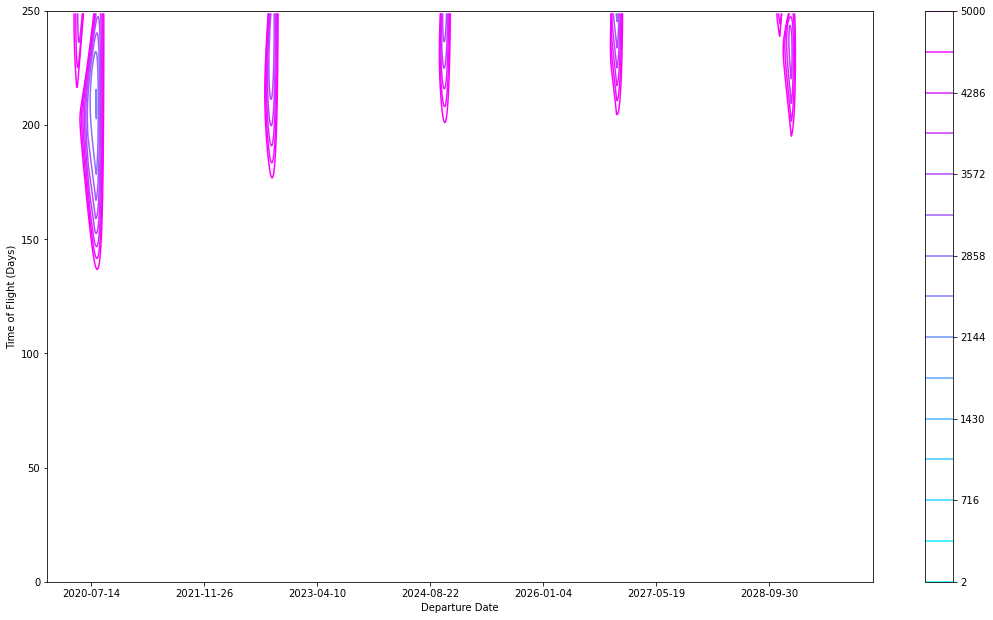

In [208]:
duration_pl, start_epochs_pl = np.meshgrid(duration, start_epochs)
plt.contour(start_epochs_pl,
            duration_pl,
            np.array(data),
            levels = list(np.linspace(best, threshold, 15)),
            cmap = 'cool')

plt.colorbar()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.xlabel('Departure Date')
plt.ylabel('Time of Flight (Days)')
new_labels = [str(i)[:10] for i in pd.to_datetime(plt.xticks()[0], unit='d', origin=pd.Timestamp('2000-01-01')).values]
plt.xticks(ticks = plt.xticks()[0], labels = new_labels)
plt.xlim(start_date, end_date)
plt.ylim(0, max_tof)
plt.show()

In [246]:
def launch_dates(start_date, end_date, max_tof, dv_thresh):
    
    start_epochs = np.arange(start_date, end_date, 1)
    duration = np.arange(0.0, max_tof, 1.0)
    
    earth = pk.planet.jpl_lp('earth')
    mars = pk.planet.jpl_lp('mars')
    
    l_probs = {}
    
    data = list()

    for start in start_epochs:
        row = list()

        for tof in duration:

            pos_1, v1 = earth.eph(pk.epoch(start, 'mjd2000'))
            pos_2, v2 = mars.eph(pk.epoch(start + tof, 'mjd2000'))

            seconds_elapsed = tof * 60 * 60 * 24 if tof > 0 else 1 * 60 *60 * 24

            l = pk.lambert_problem(pos_1, pos_2, seconds_elapsed, pk.MU_SUN)

            DV1 = np.linalg.norm(np.array(v1) - np.array(l.get_v1()[0]) )
            DV2 = np.linalg.norm(np.array(v2) - np.array(l.get_v2()[0]) )

            DV1 = max([0, DV1 - 4000])
            DV = DV1+DV2

            row.append(DV)

        data.append(row)
    
    launch_epochs = set()
    combos = []

    for i in np.argwhere(np.array(data) < dv_thresh):
        launch_epochs.add(start_epochs[i[0]])
        launch_date = start_epochs[i[0]]
        tof = duration[i[1]]
        delta_v = data[i[0]][i[1]]
        combos.append((launch_date, tof, delta_v))
    
    return launch_epochs, combos

In [247]:
start_date = 7305.0 
end_date = 10959.0
max_tof = 300
dv_thresh = 5000

dates, combos = launch_dates(start_date, end_date, max_tof, dv_thresh)

In [248]:
len(dates), combos[0]

(569, (7424.0, 239.0, 4995.117690153212))

In [236]:
start = combos[0][0]
tof = combos[0][1]

pos_1, v1 = earth.eph(pk.epoch(start, 'mjd2000'))
pos_2, v2 = mars.eph(pk.epoch(start + tof, 'mjd2000'))

seconds_elapsed = tof * 60 * 60 * 24 if tof > 0 else 1 * 60 *60 * 24

l = pk.lambert_problem(pos_1, pos_2, seconds_elapsed, pk.MU_SUN)